This is a gradient boosting model, it builds many trees sequentially, each new tree fixing the errors of the previous ones.
It takes the values of our variables for a given day and tells us if **that day** there is a short squeeze, which is fun to do but does not answer our question of prediction so yayyy, ill try to find a way to make this useful 

In [1]:
import pandas as pd
import numpy as np
import requests
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# URL to the GitHub folder (NOT raw, NOT the file, but the folder)
api_url = "https://api.github.com/repos/HardyUnine/ML_Project/contents/plan_b"

# Get list of files in the folder
files = requests.get(api_url).json()

# Extract only CSV file URLs
csv_urls = [f["download_url"] for f in files if f["name"].endswith(".csv")]

# Load all CSVs into one dataframe
dfs = []
for url in csv_urls:
    data = pd.read_csv(url)
    data["source_file"] = url.split("/")[-1].replace(".csv", "")  # optional tag
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)


# df = pd.read_csv("nom_a_changer.csv") # CHANGE CSV NAME HERE ZZ
# df.head()

# # Cant have white space between words when wanting to draw trees!!

In [3]:
df.drop(['DAY', 'TICKER', 'COMPANY_NAME', 'source_file'], axis=1, inplace=True)

df.head()

,TOTAL_SHARES,SIR,RSI,BF,ADV,PUBLIC,PRICE_PER_SHARE,SS
0,500000000,25,50,0.100,30000000,480000000,100.0,0
1,500000000,25,48,0.097,29500000,480000000,98.5,0
2,500000000,25,46,0.094,29000000,480000000,97.0,0
3,500000000,25,44,0.091,28500000,480000000,95.5,0
4,500000000,25,42,0.088,28000000,480000000,94.0,0


In [4]:
# Split data in dependent and independant variables
X = df.drop(columns=["SS"])

print(X.head())

y = df["SS"].copy()
print(y.head())

   TOTAL_SHARES  SIR  RSI     BF       ADV     PUBLIC  PRICE_PER_SHARE
0     500000000   25   50  0.100  30000000  480000000            100.0
1     500000000   25   48  0.097  29500000  480000000             98.5
2     500000000   25   46  0.094  29000000  480000000             97.0
3     500000000   25   44  0.091  28500000  480000000             95.5
4     500000000   25   42  0.088  28000000  480000000             94.0
0    0
1    0
2    0
3    0
4    0
Name: SS, dtype: int64


In [5]:
print(sum(y)/len(y)) # to check how many positives we have
# sum of how many squeezes, divided by total 
# data will probably be inbalances (ex. 30% squeezes) so need to make sure that there is 30% in both the train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) # stratify = yes, we want same percetages everywjere

print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test)) # check that they have the same percentages of squeezes

0.26071428571428573
0.2619047619047619
0.2571428571428571


In [6]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "binary",        # change to "multiclass" if >2 classes
    "metric": "binary_logloss",   # or "multi_logloss"
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

# Train model
clf_lgb = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    #early_stopping_rounds=50,
)

# Predictions (rounded to 0/1 for binary classification)
y_pred_prob = clf_lgb.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred) # confusion matrixes

print("Accuracy:", acc)

cm_df = pd.DataFrame(
    cm,
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

print(cm_df)

Accuracy: 0.95
                 Predicted Negative  Predicted Positive
Actual Negative                 100                   4
Actual Positive                   3                  33


NameError: name 'plt' is not defined

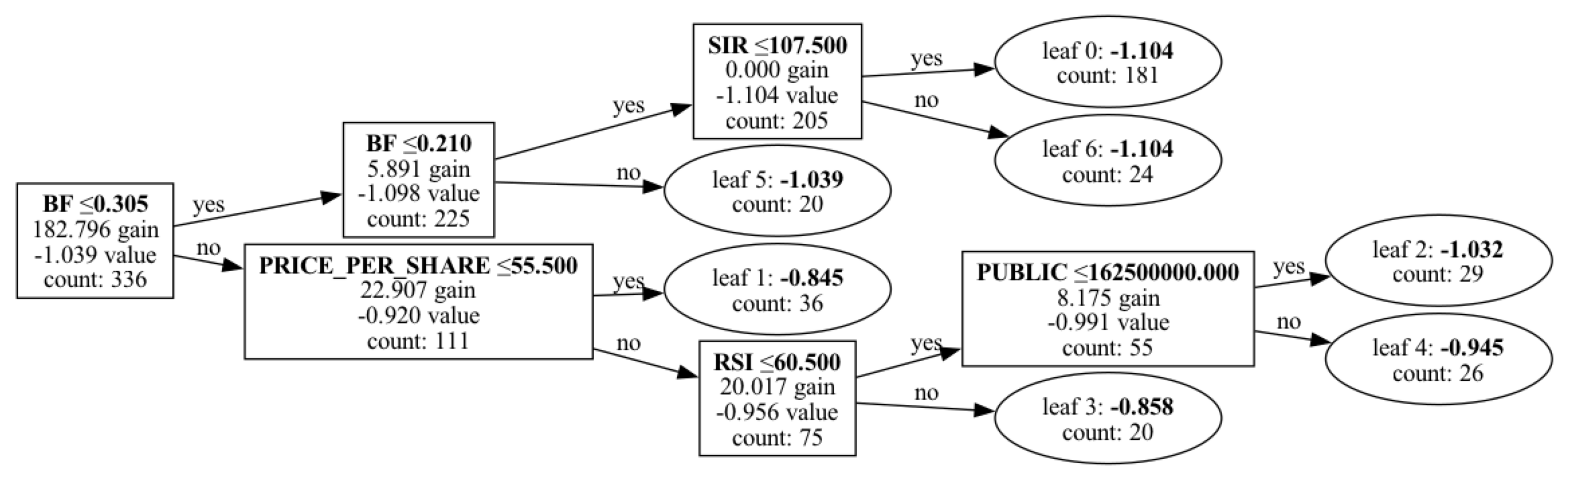

In [7]:
ax = lgb.plot_tree(clf_lgb, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()
        